Complete the exercises below For **Assignment #11**.

For this assignment we'll use the [California Housing Data](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).

This data is available in the [Scikit-Learn](https://scikit-learn.org/stable/index.html) Python module.

To retrieve the data,
1. open a new Python notebook with the `data730` kernel, and,
2. run the following code.

```python
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

(
    california_housing.data
    .assign(MedianHouseValue=california_housing.target)
    .to_csv('california-housing.csv', index=False)
)
```

This will produce a new file called `california-housing.csv` that we'll import in this notebook.

Back in the Python notebook, you can use the following snippet to get a description of the dataset.

```python
print(california_housing.DESCR)
```


Load the `tidymodels` package.

In [24]:
suppressPackageStartupMessages({
    library(tidymodels)
    library(ranger)
    library(vip)
    library(mapdata)
})

Run the following cell to read in our data.

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.3252,41,6.984127,1.0238095,322,2.555556,37.88,-122.23,4.526
8.3014,21,6.238137,0.9718805,2401,2.109842,37.86,-122.22,3.585
7.2574,52,8.288136,1.0734463,496,2.802260,37.85,-122.24,3.521
5.6431,52,5.817352,1.0730594,558,2.547945,37.85,-122.25,3.413
3.8462,52,6.281853,1.0810811,565,2.181467,37.85,-122.25,3.422
4.0368,52,4.761658,1.1036269,413,2.139896,37.85,-122.25,2.697


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


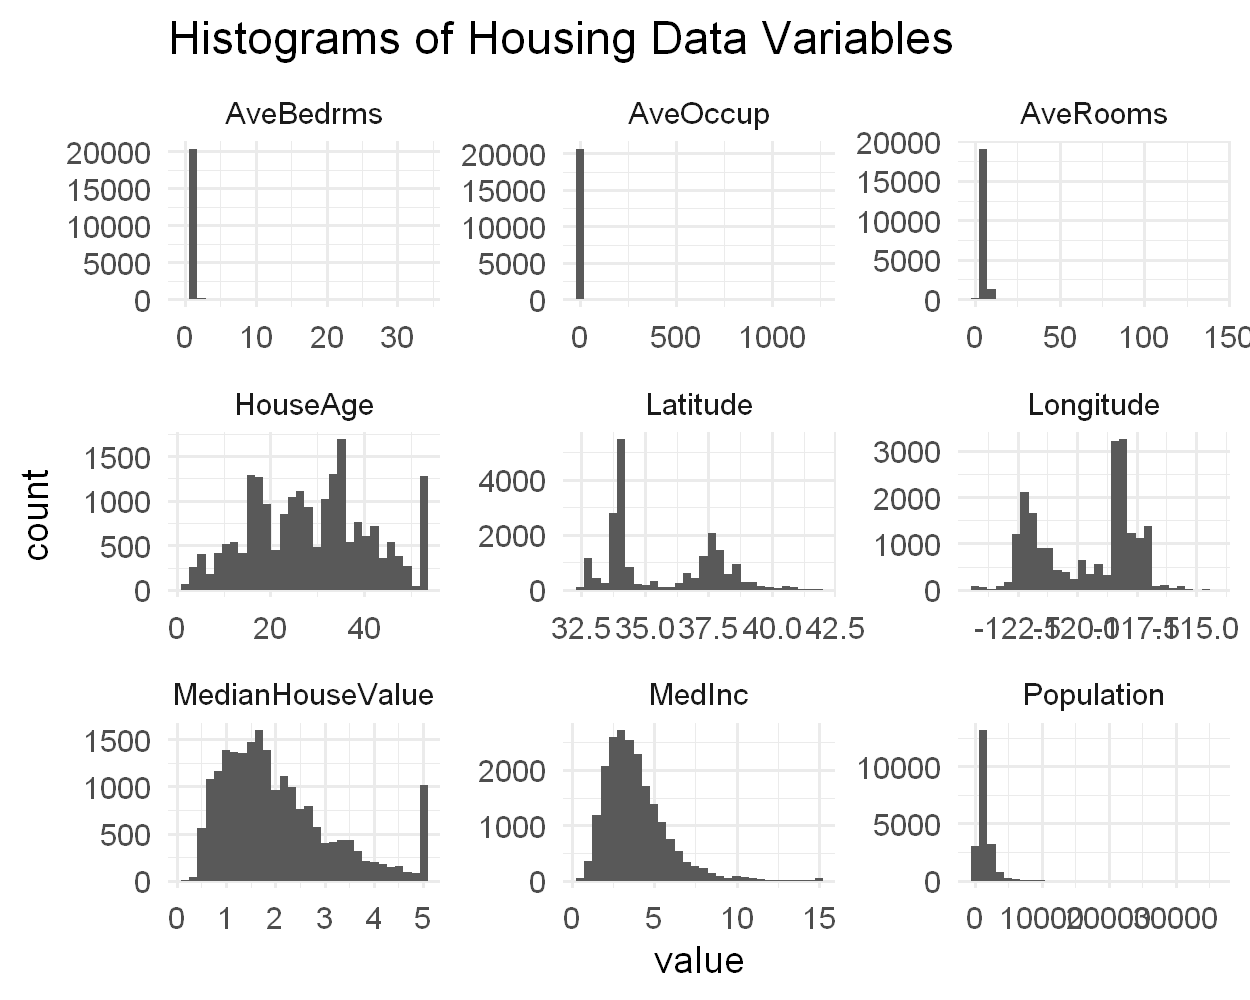

In [25]:
housing = readr::read_csv('california-housing.csv', col_types = readr::cols())

housing |> head()
# generate a histogram of each column in [ housing ], faceting by column name and allowing both axes to be free
housing |>
    tidyr::pivot_longer(cols = everything(), names_to = 'variable', values_to = 'value') |>
    ggplot2::ggplot(ggplot2::aes(x = value)) +
    ggplot2::geom_histogram() +
    ggplot2::facet_wrap(~ variable, scales = 'free') +
    ggplot2::theme_minimal() +
    ggplot2::labs(title = 'Histograms of Housing Data Variables')

Let's build a random forest model to predict `MedianHouseValue`.

1. Create your model, set the engine to `ranger` with `importance = 'impurity'` and the mode as `regression`.
2. Fit the model using `MedianHouseValue` as the response variable and all other columns as predictors.

In [26]:
# define a random forest model with the `ranger` engine
rf_model_spec <- 'regression' |>
    rand_forest(
        trees = 1000,
        min_n = 5
    ) |>
    set_engine(
        'ranger',
        importance = 'impurity',
        num.threads = parallel::detectCores()
    )

# fit thee model, using `MedianHouseValue` as the response variable and all other columns as predictors/regressors
rf_model_fit <- rf_model_spec |>
    generics::fit(
        MedianHouseValue ~ .,
        data = housing
    )

rf_model_fit

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~1000,      min.node.size = min_rows(~5, x), importance = ~"impurity",      num.threads = ~parallel::detectCores(), verbose = FALSE,      seed = sample.int(10^5, 1)) 

Type:                             Regression 
Number of trees:                  1000 
Sample size:                      20640 
Number of independent variables:  8 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.232887 
R squared (OOB):                  0.8251094 

❓ What is the OOB error for this model?

**Answer:**

The OOB error is 0.23, which equates to a root MSE of ~0.48. This value can be interpreted as an average prediction error of ~$48,000 in predicted median home value.

Plot the feature importances using the `vip` package. Remember that you can use the `extract_fit_engine` function to get the `ranger` model object to send to the `vip` function.

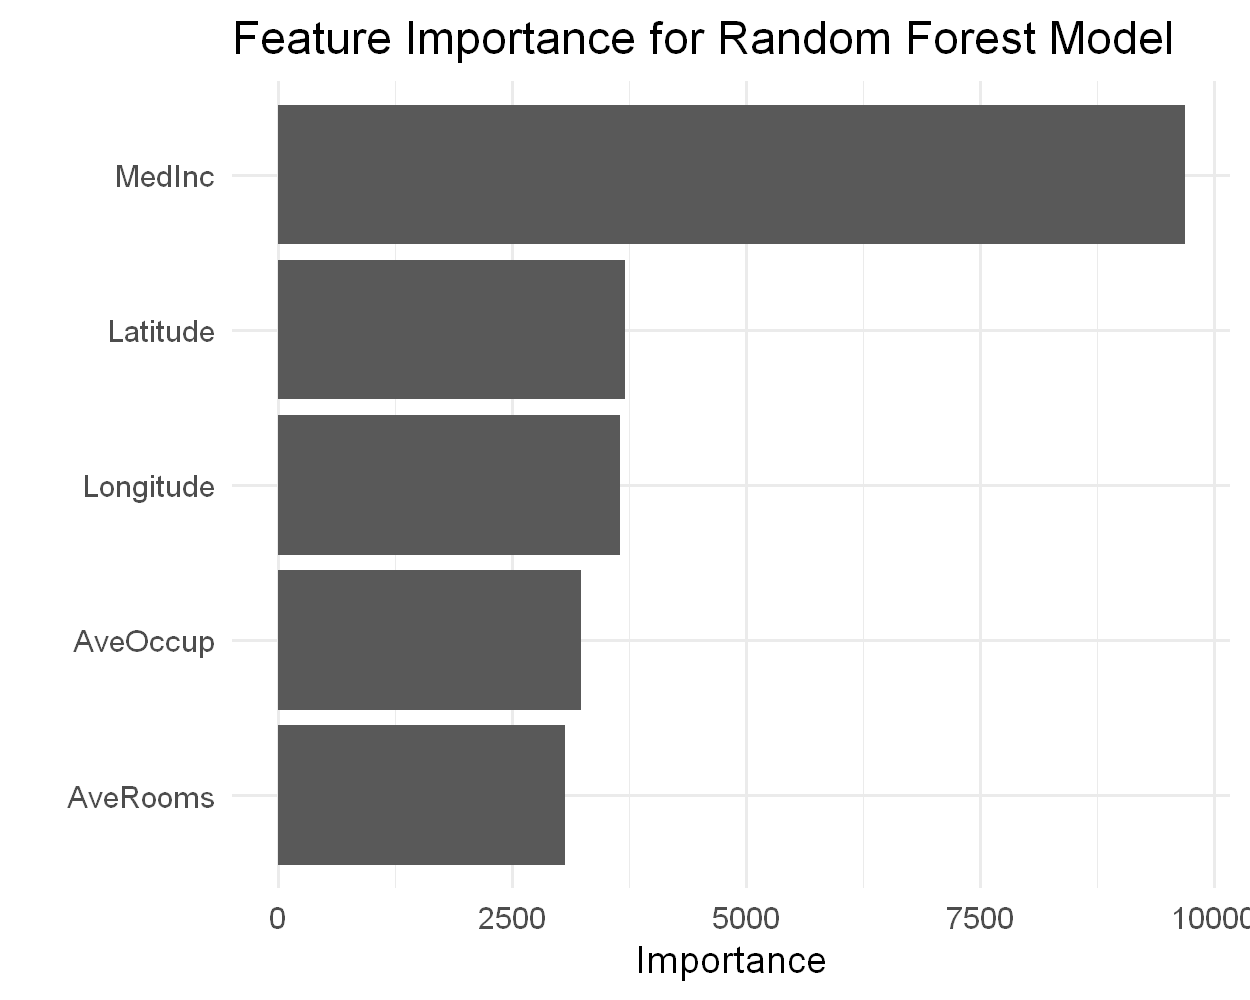

In [27]:
rf_model_fit |>
    vip::vip(num_features = 5) +
    ggplot2::ggtitle('Feature Importance for Random Forest Model') +
    ggplot2::theme_minimal()

It looks like `Latitude` and `Longitude` are important for predicting home value. Let's explore those variables.

Install the `mapdata` package into your `data730` environment.

1. Open a Terminal, and,
2. Run the following command:

```bash
conda install -c conda-forge -n data730 r-mapdata
```

Load the `mapdata` package.

The following code will generate a map of California. Adapt this code to plot `Latitude` and `Longitude` from the `housing` dataset, color points by the `MedianHouseValue`. [Here is an example for reference](https://raw.githubusercontent.com/UNC-DATA-730/a10/main/example.png).


```r
california = map_data("state") |> filter(region == 'california')

ggplot(data = california) + 
    geom_polygon(aes(x = long, y = lat), fill = "grey90", color = "grey40") +
    coord_quickmap() +
    theme_void()
```

Rows: 516
Columns: 6
$ long      <dbl> -120.0060, -120.0060, -120.0060, -119.9946, -120.0060, -120.…
$ lat       <dbl> 42.00927, 41.20139, 39.70024, 39.44241, 39.31636, 39.16166, …
$ group     <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, …
$ order     <int> 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, …
$ region    <chr> "california", "california", "california", "california", "cal…
$ subregion <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …


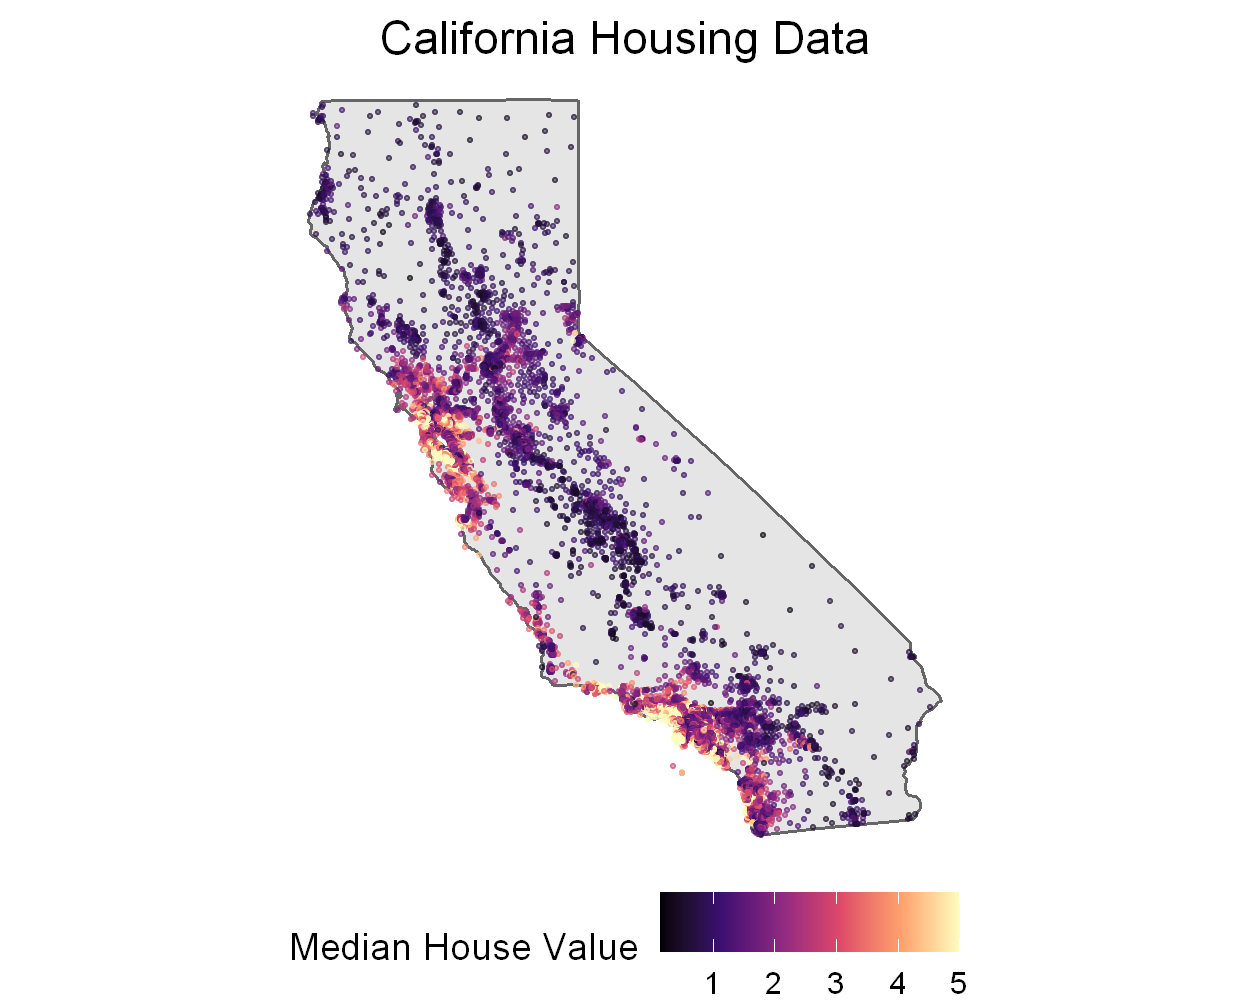

In [28]:
california <- map_data('state') |>
    filter(
        region == 'california'
    )

glimpse(california)

# plot the state of California
california |>
    ggplot(
        aes(
            x = long,
            y = lat
        )
    ) +
    geom_polygon(
        fill = 'grey90',
        color = 'grey40'
    ) +
    coord_quickmap() +
    theme_void() +
    # overlay the housing data, plotting `Latitude` on the x-axis, `Longitude` on the y-axis, and coloring by `MedianHouseValue` using the viridis palette
    geom_point(
        data = housing,
        aes(
            x = Longitude,
            y = Latitude,
            color = MedianHouseValue
        ),
        alpha = 0.5,
        size = 0.5
    ) +
    scale_color_viridis_c(
        option = 'magma',
        name = 'Median House Value'
    ) +
    ggtitle('California Housing Data') +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = 'bottom'
    )